In [8]:
!pip install tensorflow
!pip install tensorflow_text
!pip install simpleneighbors
!pip install -U scikit-learn
!pip install -U pip setuptools wheel
!pip install -U spacy
!pip install pandas
!pip install matplotlib
!pip install seaborn

     |████████████████████████████████| 4.9 MB 20.2 MB/s            
     |████████████████████████████████| 489.6 MB 53 kB/s              
     |████████████████████████████████| 108 kB 49.7 MB/s            
     |████████████████████████████████| 4.1 MB 49.7 MB/s            
     |████████████████████████████████| 463 kB 56.7 MB/s            
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 84 kB 10.7 MB/s            
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     |████████████████████████████████| 126 kB 57.5 MB/s            
  Using cached protobuf-3.19.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 2.1 MB 26.3 MB/s            
     |███████████

In [3]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 12.3 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [1]:
import os
import json
import gzip
import dask
from dask.diagnostics import ProgressBar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy 
import nltk
from nltk.util import everygrams
from tqdm import tqdm
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
from tensorflow_text import SentencepieceTokenizer
import sklearn.metrics.pairwise
from simpleneighbors import SimpleNeighbors
from collections import Counter

sns.set()
tqdm.pandas()

## Pre-process data

In [3]:
# Download data from: https://nijianmo.github.io/amazon/index.html
!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz

--2021-12-20 18:57:52--  http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7010521 (6,7M) [application/octet-stream]
Saving to: ‘meta_Computers.json.gz.1’

meta_Computers.json 100%[===================>]   6,69M  1,79MB/s    in 4,3s    

2021-12-20 18:57:57 (1,56 MB/s) - ‘meta_Computers.json.gz.1’ saved [7010521/7010521]



In [2]:
data = []
with gzip.open('meta_Computers.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
        
data_df = pd.DataFrame(data)
data_df

,description,title,image,brand,rank,main_cat,date,asin,feature,tech1,also_buy,price,also_view,tech2,details,similar_item
0,[Brand new. Still in factory-sealed plastic.],Kelby Training DVD: The Adobe Photoshop CS5 7-...,[https://images-na.ssl-images-amazon.com/image...,Kelby Training,"[>#654,681 in Electronics (See Top 100 in Elec...",Computers,"December 2, 2011",0321732960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[If you're already a Photoshop user and want a...,Kelby Training DVD: Adobe Photoshop CS5 Power ...,[https://images-na.ssl-images-amazon.com/image...,Kelby Training,"[>#830,165 in Electronics (See Top 100 in Elec...",Computers,"November 7, 2011",0321735722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[School To Home Notes: Note From the Teacher!\...,TEACHERS FRIEND NOTE FROM THE TEACHER SCHOOL T...,[https://images-na.ssl-images-amazon.com/image...,TEACHERS FRIEND,"[>#1,233,887 in Electronics (See Top 100 in El...",Computers,"June 6, 2007",0439651859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[Dooqi is a young brand specializing in high-e...,"[3-pack]Ipad Mini Screen Protector, Dooqi Scre...",[https://images-na.ssl-images-amazon.com/image...,dooqi,"[>#454,595 in Electronics (See Top 100 in Elec...",Computers,"December 5, 2014",0545729971,"[Hard coated for Scratch Proof (Hardness: 4H),...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[Cover for Nook HD],Hd+ Cheetah Cover- Nook,NaN,Nook,"[>#85,661 in Computers & Accessories (See top ...",Computers,"September 11, 2013",0594450284,[Cheetah cover],"{'Brand Name': 'Nook', 'Item Weight': '1 pound...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18767,NaN,"iPad Mini 4 Case, Aceguarder New Design [Dirtp...",[https://images-na.ssl-images-amazon.com/image...,NaN,"[>#372,769 in Electronics (See Top 100 in Elec...",Computers,"July 11, 2016",B01HI72XZW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18768,NaN,MIJIU Nylon Canvas Military Tactical Men Waist...,[https://images-na.ssl-images-amazon.com/image...,NaN,"[>#308,759 in Electronics (See Top 100 in Elec...",Computers,"June 29, 2016",B01HIEI83Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18769,[Deadpool is a mercenary and anti-hero appeari...,Marvel Deadpool Laptop Backpack,[https://images-na.ssl-images-amazon.com/image...,Bioworld,"[>#4,064 in Computers & Accessories (See top 1...",Computers,"June 24, 2016",B01HIQYNJM,"[Officially Licensed, One main zippered compar...",{'Screen Size': '17 inches'},NaN,$8.62,"[B07D3ZMXBV, B0733MWQJX, B074QLZRXQ, B07G5GSQN...","{'Brand Name': 'Bioworld', 'Item model number'...",NaN,NaN
18770,NaN,Funnel Cup (Ultra Pink),[https://images-na.ssl-images-amazon.com/image...,JDDZ,"[>#449,492 in Electronics (See Top 100 in Elec...",Computers,"March 5, 2017",B01HIWBL46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Get only the text data and ID
data_df = data_df[['title', 'description', 'asin']]
data_df

,title,description,asin
0,Kelby Training DVD: The Adobe Photoshop CS5 7-...,[Brand new. Still in factory-sealed plastic.],0321732960
1,Kelby Training DVD: Adobe Photoshop CS5 Power ...,[If you're already a Photoshop user and want a...,0321735722
2,TEACHERS FRIEND NOTE FROM THE TEACHER SCHOOL T...,[School To Home Notes: Note From the Teacher!\...,0439651859
3,"[3-pack]Ipad Mini Screen Protector, Dooqi Scre...",[Dooqi is a young brand specializing in high-e...,0545729971
4,Hd+ Cheetah Cover- Nook,[Cover for Nook HD],0594450284
...,...,...,...
18767,"iPad Mini 4 Case, Aceguarder New Design [Dirtp...",NaN,B01HI72XZW
18768,MIJIU Nylon Canvas Military Tactical Men Waist...,NaN,B01HIEI83Q
18769,Marvel Deadpool Laptop Backpack,[Deadpool is a mercenary and anti-hero appeari...,B01HIQYNJM
18770,Funnel Cup (Ultra Pink),NaN,B01HIWBL46


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18772 entries, 0 to 18771
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        18771 non-null  object
 1   description  5130 non-null   object
 2   asin         18772 non-null  object
dtypes: object(3)
memory usage: 440.1+ KB


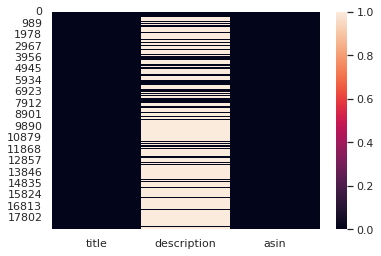

In [5]:
sns.heatmap(data_df.isnull())
plt.show()

In [6]:
# Remove items without description
data_df = data_df.loc[~data_df.isnull().values.any(1)]
data_df = data_df.reset_index(drop=True)
data_df

,title,description,asin
0,Kelby Training DVD: The Adobe Photoshop CS5 7-...,[Brand new. Still in factory-sealed plastic.],0321732960
1,Kelby Training DVD: Adobe Photoshop CS5 Power ...,[If you're already a Photoshop user and want a...,0321735722
2,TEACHERS FRIEND NOTE FROM THE TEACHER SCHOOL T...,[School To Home Notes: Note From the Teacher!\...,0439651859
3,"[3-pack]Ipad Mini Screen Protector, Dooqi Scre...",[Dooqi is a young brand specializing in high-e...,0545729971
4,Hd+ Cheetah Cover- Nook,[Cover for Nook HD],0594450284
...,...,...,...
5125,DOODEEN 2 Packs Black and Red Wired Game Pad C...,[Product discription: Compatible Controller f...,B01HFWK7X0
5126,CQRobot Raspberry Pi 2/3 Generation of Heat Si...,"[, FEATURES, - Top quality heatsinks bring you...",B01HH03NLI
5127,Classic Vintage Crazy Horse Leather Messenger ...,[Basic Information: Net weight: 1.6kg Dimensio...,B01HHIWGN6
5128,Extra Long 5 Ft AC Adapter 3A Rapid Charger Co...,[Specification 1.Compatible with: Nextbook Fle...,B01HHR2AUQ


In [10]:
nlp = spacy.load('en_core_web_sm')

In [102]:
def split_by_pos(doc, pos='PUNCT'):
    '''
    
    '''
    sents = []
    i_ = 0
    for tk in doc:
        if tk.pos_ == pos:
            sent = doc[i_:tk.i]
            sent = ' '.join([tk.text for tk in sent])
            sents.append(sent)
            i_ = tk.i + 1

    return sents

def extract_ngrams(info):
    '''
    
    '''
    # Tokenize item texts (title and description)
    item_texts = [nlp(info['title'])] + [nlp(doc) for doc in info['description']]
    # title = nlp(info['title'])
    # description = [nlp(doc) for doc in info['description']]
    
    # Clean text
    item_texts = [[tk for tk in i if tk.pos_ not in ['SYM', 'X']] for i in item_texts]
    # title = [tk for tk in title if tk.pos_ not in ['SYM', 'X']]
    # description = [[tk for tk in d if tk.pos_ not in ['SYM', 'X']] for d in description]

    # Split by punctuation
    item_texts = [split_by_pos(d) for d in item_texts]
    # title = split_by_pos(title)
    # description = [split_by_pos(d) for d in description]
    # description = [item for sublist in description for item in sublist]
    
    # Extract ngrams
    ngrams = [list(everygrams(i.split(), max_len=3)) for it in item_texts for i in it]
    ngrams = [item for sublist in ngrams for item in sublist]
    ngrams = list(set([' '.join(ngram) for ngram in ngrams]))
    
    # title_ngrams = [list(everygrams(t.split(), max_len=3)) for t in title]
    # title_ngrams = [item for sublist in title_ngrams for item in sublist]
    
    # description_ngrams = [list(everygrams(d.split(), max_len=3)) for d in description]
    # description_ngrams = [item for sublist in description_ngrams for item in sublist]
    
    # title_ngrams = [' '.join(ngram) for ngram in title_ngrams]
    # description_ngrams = [' '.join(ngram) for ngram in description_ngrams]
    
    # Filter n-grams
    filtered_ngrams = []
    for ngram in ngrams:
        doc = nlp(ngram)
        ngram_len = len(doc)
        assert(ngram_len in [1, 2, 3])
        
        # print(ngram_len, ngram, [tk.pos_ for tk in doc])
        # print(all([tk.pos_ in ['PROPN', 'NOUN', 'ADJ'] for tk in doc]))
        if ngram_len in [1, 2] and all([tk.pos_ in ['PROPN', 'NOUN', 'ADJ'] for tk in doc]):
            filtered_ngrams.append(ngram)
                
        elif ngram_len == 3:
            filtered_ngrams.append(ngram)
            
        else: 
            pass
    
    return filtered_ngrams

In [106]:
txt = data_df.iloc[20]
print(txt)
import time
t_start = time.time()
print(extract_ngrams(txt))
print(time.time() - t_start)

title                                 ViewSonic E790 19" Monitor
description    [The ViewSonic E-790 19-inch monitor provides ...
asin                                                  B00004TS2P
Name: 20, dtype: object
['CAM', 'at 76 Hz', 'parts', 'sharp images .', 'dot pitch', 'delivers sharp images', 'dot', 'vertical', 'fine resolution', 'delivered through optimized', 'the purchase of', 'Wide', 'CAD CAM', 'backlight are all', 'features an 18', 'innovative', 'antiglare glass', 'position', 'less of your', 'multiple', 'practical up -', 'PC ready and', 'limited warranty', 'moir reduction', 'labor', 'monitor provides creative', 'screen with a', 'through optimized antiglare', 'focus and vivid', 'and Macintosh compatible', 'pitch and a', 'hook control ,', 'year', 'and innovative features', 'superfine dot pitch', 'large screen size', 'display', 'flexibility and fine', 'It features an', 'users to see', 'free resolution', 'sharp', 'valuable desk', 'crisp focus', 'on and off', 'purchase', 'desk

In [8]:
# Compute valuable n-grams from each item
data_df['ngrams'] = data_df.progress_apply(lambda r: extract_ngrams(r), axis=1)
data_df

100%|████████████████████████████████████████████████████████████| 5130/5130 [06:09<00:00, 13.87it/s]


,title,description,asin,keywords
0,Kelby Training DVD: The Adobe Photoshop CS5 7-...,[Brand new. Still in factory-sealed plastic.],0321732960,"[Raw, Adobe, CS5, System, Scott, point, Kelby,..."
1,Kelby Training DVD: Adobe Photoshop CS5 Power ...,[If you're already a Photoshop user and want a...,0321735722,"[Matt, Power, Adobe, CS5, Session, Kelby, trai..."
2,TEACHERS FRIEND NOTE FROM THE TEACHER SCHOOL T...,[School To Home Notes: Note From the Teacher!\...,0439651859,"[note, SCHOOL, FRIEND, NOTE, teacher, TEACHERS..."
3,"[3-pack]Ipad Mini Screen Protector, Dooqi Scre...",[Dooqi is a young brand specializing in high-e...,0545729971,"[Ipad, install, Green, Protector, pack]ipad, i..."
4,Hd+ Cheetah Cover- Nook,[Cover for Nook HD],0594450284,"[Nook, Cheetah, hd+, Cover-, Nook, HD]"
...,...,...,...,...
5125,DOODEEN 2 Packs Black and Red Wired Game Pad C...,[Product discription: Compatible Controller f...,B01HFWK7X0,"[Joypad, doodeen, Red, pack, Black, Wired, Pad..."
5126,CQRobot Raspberry Pi 2/3 Generation of Heat Si...,"[, FEATURES, - Top quality heatsinks bring you...",B01HH03NLI,"[Dedicated, Heat, Package, Heatsinks, Cooling,..."
5127,Classic Vintage Crazy Horse Leather Messenger ...,[Basic Information: Net weight: 1.6kg Dimensio...,B01HHIWGN6,"[Messenger, Crazy, Tote, laptop, Office, Class..."
5128,Extra Long 5 Ft AC Adapter 3A Rapid Charger Co...,[Specification 1.Compatible with: Nextbook Fle...,B01HHR2AUQ,"[3A, NXW9QC132, Tablet, Flexx, Adapter, Charge..."


#### Checkpoint

In [21]:
data_df.to_csv('ecommerce_products_processed_1.csv', index=False, encoding='utf8')

In [6]:
data_df = pd.read_csv('ecommerce_products_processed_1.csv')
data_df['ngrams'] = data_df['ngrams'].apply(lambda x: x.strip('[]').replace('\'','').split(', '))

data_df

,Unnamed: 0,title,description,asin,ngrams
0,0,Kelby Training DVD: The Adobe Photoshop CS5 7-...,['Brand new. Still in factory-sealed plastic.'],0321732960,"[Raw, Adobe, CS5, System, Scott, point, Kelby,..."
1,1,Kelby Training DVD: Adobe Photoshop CS5 Power ...,"[""If you're already a Photoshop user and want ...",0321735722,"[Matt, Power, Adobe, CS5, Session, Kelby, trai..."
2,2,TEACHERS FRIEND NOTE FROM THE TEACHER SCHOOL T...,['School To Home Notes: Note From the Teacher!...,0439651859,"[note, SCHOOL, FRIEND, NOTE, teacher, TEACHERS..."
3,3,"[3-pack]Ipad Mini Screen Protector, Dooqi Scre...","[""Dooqi is a young brand specializing in high-...",0545729971,"[Ipad, install, Green, Protector, pack]ipad, i..."
4,4,Hd+ Cheetah Cover- Nook,['Cover for Nook HD'],0594450284,"[Nook, Cheetah, hd+, Cover-, Nook, HD]"
...,...,...,...,...,...
5125,5125,DOODEEN 2 Packs Black and Red Wired Game Pad C...,['Product discription: Compatible Controller ...,B01HFWK7X0,"[Joypad, doodeen, Red, pack, Black, Wired, Pad..."
5126,5126,CQRobot Raspberry Pi 2/3 Generation of Heat Si...,"['', 'FEATURES', '- Top quality heatsinks brin...",B01HH03NLI,"[Dedicated, Heat, Package, Heatsinks, Cooling,..."
5127,5127,Classic Vintage Crazy Horse Leather Messenger ...,['Basic Information: Net weight: 1.6kg Dimensi...,B01HHIWGN6,"[Messenger, Crazy, Tote, laptop, Office, Class..."
5128,5128,Extra Long 5 Ft AC Adapter 3A Rapid Charger Co...,"[""Specification 1.Compatible with: Nextbook Fl...",B01HHR2AUQ,"[3A, NXW9QC132, Tablet, Flexx, Adapter, Charge..."


## Embeddings

In [107]:
# ['https://tfhub.dev/google/universal-sentence-encoder-multilingual/3', 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3']
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' 
embedding_dim = 512

embedding_model = hub.load(module_url)

index = SimpleNeighbors(embedding_dim, metric='dot')

2021-12-28 16:57:03.251269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 16:57:03.289784: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-12-28 16:57:03.289802: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-28 16:57:03.290758: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [109]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('Embedding with GPU')
    for idx, row in tqdm(data_df.iterrows()):
        index.feed([(row['asin'], embedding_model(t)[0]) for t in [row['title']] + row['description']])
        # index.feed([(row['asin'], embedding_model(t)[0]) for t in row['ngrams']])
    
else:
    print('Embedding with CPU')
    delayed_results = []
    for idx, row in data_df.iterrows():
        task = dask.delayed(lambda r: [(r['asin'], embedding_model(t)[0]) for t in [r['title']] + r['description']])(row)
        # task = dask.delayed(lambda r: [(r['asin'], embedding_model(t)[0]) for t in r['ngrams']])(row)
        delayed_results.append(task)
    
    with ProgressBar():
        results = dask.compute(*delayed_results)  
        
    print('Feeding index...')
    results = [item for sublist in results for item in sublist]
    index.feed(results)
    

print('Building index...')
index.build(n=40)

Embedding with CPU
[########################################] | 100% Completed |  2min 47.6s
Feeding index...
Building index...


#### Checkpoint

In [110]:
index.save('index_2')

In [3]:
index = SimpleNeighbors(embedding_dim, metric='dot')
index = index.load('index_2')

## Semantic search

In [111]:
sample_query = 'Ipad Mini Screen Protector'  
num_results = 100

query_embedding = embedding_model(sample_query)[0]
search_results = index.nearest(query_embedding, n=num_results)

search_results = Counter(search_results)
search_results

# search_results = dict(sorted(Counter(search_results).items(), key=lambda item: item[1], reverse=True))
# search_results

Counter({'B01H0OG21E': 2,
         'B01CE2RJD2': 1,
         'B01GP0YULI': 1,
         'B00C0NN4BC': 1,
         'B00NMMQN86': 1,
         '0545729971': 1,
         'B00O5MA4OG': 1,
         'B014E6IV7O': 1,
         'B00CM60E5G': 1,
         'B00BB75KVU': 1,
         'B00K3I9SV6': 6,
         'B00JQYJ9QM': 2,
         'B008MJ8THM': 2,
         'B00HYL7APQ': 1,
         'B00JQYJB2E': 2,
         'B00JQYHO32': 2,
         'B00JQYHW20': 2,
         'B00JQYHV1C': 2,
         'B00JQYHTZA': 2,
         'B00JQYHOSM': 2,
         'B00JQYIDBO': 2,
         'B00C6QLFRS': 1,
         'B00P115MSI': 1,
         'B000HL917A': 1,
         'B01ACTBPJI': 1,
         'B004U3NRN0': 1,
         'B00AHDY038': 2,
         'B0143KLQR8': 2,
         'B00DSLO73O': 1,
         'B004USV7TQ': 2,
         'B01FIGN2QY': 1,
         'B00JQEQHMG': 1,
         'B00EPY0Q7O': 1,
         'B00GRUOUXK': 1,
         'B00JQYHMSE': 1,
         'B00OBRRFGU': 1,
         'B00JQYI742': 1,
         'B009YJYK5Y': 1,
         'B0

In [113]:
print('Most related items to:', sample_query)
print()
for idx, (k, v) in enumerate(search_results.items()):
    result = data_df.loc[data_df['asin'] == k]
    assert(len(result) == 1)
    result = result.iloc[0]
    
    print(idx, result['title'])    
    print(result['description'])
    # print(result['description'].replace('[\'', '').replace('["', '').replace('\']', '').replace('"]', '').replace('\\n', '\n'))
    print()

Most related items to: Ipad Mini Screen Protector

0 BEST Tempered Shatter- Proof & Scratch Resistant Screen Protector for Ipad Mini 4 (2016+) - 5X The Resistance to Other Screen Protectors
['iPad Mini 4 Tempered Glass Screen Protector']

1 ESR iPad Screen Protector
['PartialUpdate']

2 iMounTEK Tempered Glass Screen Protector for iPad Mini 1/2/3
['Size: 7.9 inches Thickness: 0.4mm Hardness level: 9H Edges: straight Transmittance: 98% Weight: 1.04oz Package size: 9.2"6.7"0.25"LWH Package weight: 3.57oz']

3 3-pieces Reusable Anti-glare Screen Protector Compatible With Apple iPad Mini
['* 99% UV Protection: Reduces eye strain caused by the LCD screen. * Anti-Scratch Film: Thickest and most durable. * 99% Transparent: Unmatched clarity.  * Washable and Reusable: Never need to buy another screen protector again  * Silicone Adhesive Coating: No glue residue when removed. U * ltra Smooth Surface: Enhance the experience and utilization of touch screen and stylus features. * Includes:3 x Reus

AssertionError: 